In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 准备数据

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
# print(housing.data[0:5])
import pprint  #打印的格式比较 好看

pprint.pprint(housing.data[0:5])
print('-'*50)
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
--------------------------------------------------
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split

#拆分训练集和测试集，random_state是随机种子,同样的随机数种子，是为了得到同样的随机值
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
# 训练集
print(x_train.shape, y_train.shape)
# 验证集
print(x_valid.shape, y_valid.shape)
# 测试集
print(x_test.shape, y_test.shape)

dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test": [x_test, y_test],
}


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader


scaler = StandardScaler()
scaler.fit(x_train)

StandardScaler()

### 构建数据集

这里我们构建多输入的数据集，注意到数据集介绍里对每个特征定义如下：

> **Attribute Information**:
> - MedInc        median income in block group
> - HouseAge      median house age in block group
> - AveRooms      average number of rooms per household
> - AveBedrms     average number of bedrooms per household
> - Population    block group population
> - AveOccup      average number of household members
> - Latitude      block group latitude
> - Longitude     block group longitude

我们认为最后两维作为位置信息要单独处理，故制作数据集如下

In [6]:
from torch.utils.data import Dataset

class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        self.x, self.y = dataset_maps[mode]
        self.x = torch.from_numpy(scaler.transform(self.x)).float()
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)
            
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return (self.x[idx],self.x[idx][-2:]), self.y[idx] #返回的是一个元组，元组里面是两个元素，第一个元素是一个元组，第二个元素是一个数。self.x[idx][-2:]代表取最后两个元素
    
    
train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

In [7]:
train_ds[1]

((tensor([-0.2981,  0.3523, -0.1092, -0.2506, -0.0341, -0.0060,  1.0806, -1.0611]),
  tensor([ 1.0806, -1.0611])),
 tensor([1.5140]))

### DataLoader

In [8]:
from torch.utils.data import DataLoader


batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

## 定义模型

In [9]:
#回归模型我们只需要1个数

class WideDeep(nn.Module):
    def __init__(self, input_dim=(8,2)):
        super().__init__()
        self.deep = nn.Sequential(
            nn.Linear(input_dim[1], 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU()
            )
        # pytorch 需要自行计算输出输出维度
        self.output_layer = nn.Linear(30 + input_dim[0], 1)
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        
    def forward(self, x_wide, x_deep):
        # x_deep.shape [batch size, 6]
        deep_output = self.deep(x_deep)
        # concat [batch size, 30] with [batch size 8]
        concat = torch.cat([x_wide, deep_output], dim=1)
        logits = self.output_layer(concat)
        # logits.shape [batch size, 1]
        return logits

In [10]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [11]:
model = WideDeep()
model

WideDeep(
  (deep): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
  )
  (output_layer): Linear(in_features=38, out_features=1, bias=True)
)

In [12]:
for name, param in model.named_parameters():
      print(name, param.shape)

deep.0.weight torch.Size([30, 2])
deep.0.bias torch.Size([30])
deep.2.weight torch.Size([30, 30])
deep.2.bias torch.Size([30])
output_layer.weight torch.Size([1, 38])
output_layer.bias torch.Size([1])


In [13]:
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for (datas_deep, datas_wide), labels in dataloader:
        datas_deep = datas_deep.to(device)
        datas_wide = datas_wide.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas_deep, datas_wide)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())
        
    return np.mean(loss_list)


In [14]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for (datas_deep, datas_wide), labels in train_loader:#和上面自定义的dataset是一致的
                datas_deep = datas_deep.to(device)
                datas_wide = datas_wide.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas_deep, datas_wide)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 10



# 1. 定义损失函数 采用MSE损失
loss_fct = nn.MSELoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5, min_delta=1e-3)

model = model.to(device)
record = training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/14520 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

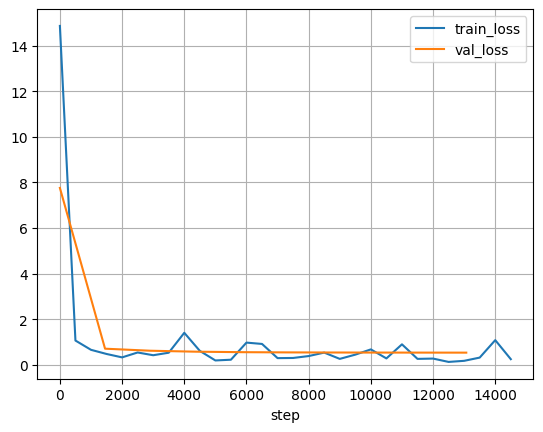

In [15]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

## 测试集

In [16]:
model.eval()
loss = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}")

loss:     0.5345
